In [2]:
import os

import nibabel as nib
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.ndimage import affine_transform, zoom
from scipy.stats import zscore
from skimage.transform import resize

import h5py

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors



In [3]:
cortical_atlas_path = '/Users/yibeichen/Desktop/fusi/atlas/atlas_MBM_cortex_vH.nii.gz'
subcortical_atlas_path = '/Users/yibeichen/Desktop/fusi/atlas/atlas_MBM_subcortical_beta.nii.gz'
chunk_nifti_path = '/Users/yibeichen/Desktop/fusi/chunk2whole/Zion_3D_corrected-transformed.nii.gz'

In [4]:
cortical_atlas_img = nib.load(cortical_atlas_path)
subcortical_atlas_img = nib.load(subcortical_atlas_path)
chunk_img = nib.load(chunk_nifti_path)

# Get the data arrays from the NIfTI images
cortical_atlas_data = cortical_atlas_img.get_fdata()
subcortical_atlas_data = subcortical_atlas_img.get_fdata()
chunk_data = chunk_img.get_fdata()

# Get the affine matrices
cortical_atlas_affine = cortical_atlas_img.affine
subcortical_atlas_affine = subcortical_atlas_img.affine
chunk_affine = chunk_img.affine

In [5]:
cortical_atlas_data.shape, subcortical_atlas_data.shape, chunk_data.shape

((147, 200, 135), (147, 200, 135), (74, 200, 135))

In [458]:
from scipy.ndimage import affine_transform

# Calculate the transformation matrix to align the chunk with the atlas
transform_matrix = np.linalg.inv(chunk_affine).dot(cortical_atlas_affine)

# Apply the transformation to the chunk data
aligned_chunk_data = affine_transform(chunk_data, transform_matrix)

# Apply the same transformation to the highlight mask
aligned_chunk_highlight = affine_transform(chunk_highlight, transform_matrix)


In [6]:
def plot_slices(data, axes=(0, 1, 2), titles=None):
    # Determine the dimensions of the data
    dim_x, dim_y, dim_z = data.shape
    slice_indices = [dim_x // 2, dim_y // 2, dim_z // 2]
    
    # Calculate the width ratios based on the dimensions of the slices
    width_ratios = []
    for axis in axes:
        if axis == 0:
            width_ratios.append(dim_x / dim_z)
        elif axis == 1:
            width_ratios.append(dim_y / dim_z)
        else:
            width_ratios.append(dim_x / dim_y)
    
    total_width_ratio = sum(width_ratios)
    fig_width = 12  # Total width of the figure
    fig_height = 6  # Height of the figure
    fig = plt.figure(figsize=(fig_width, fig_height))
    
    # Calculate normalized width ratios
    normalized_ratios = [w / total_width_ratio for w in width_ratios]
    
    # Current left position for placing the subplot
    current_left = 0
    
    # Store the images to be used for the colorbar
    images = []
    
    # Iterate over the slices to plot
    for i, (slice_index, axis) in enumerate(zip(slice_indices, axes)):
        ax_width = normalized_ratios[i] * 0.9  # Reduce width slightly to avoid overlap
        ax = fig.add_axes([current_left, 0.1, ax_width, 0.8])  # [left, bottom, width, height]
        
        if axis == 0:
            slice_data = data[0, :, :]
        elif axis == 1:
            slice_data = data[:, slice_index, :]
        else:
            slice_data = data[:, :, slice_index]
        
        im = ax.imshow(np.rot90(slice_data), cmap='nipy_spectral')
        images.append(im)
        
        if titles:
            ax.set_title(titles[i])
        
        current_left += ax_width
    
    # Add a single colorbar for all images
    cbar_ax = fig.add_axes([0.93, 0.1, 0.02, 0.8])  # Adjust left position to avoid overlap
    fig.colorbar(images[0], cax=cbar_ax)
    
    plt.show()

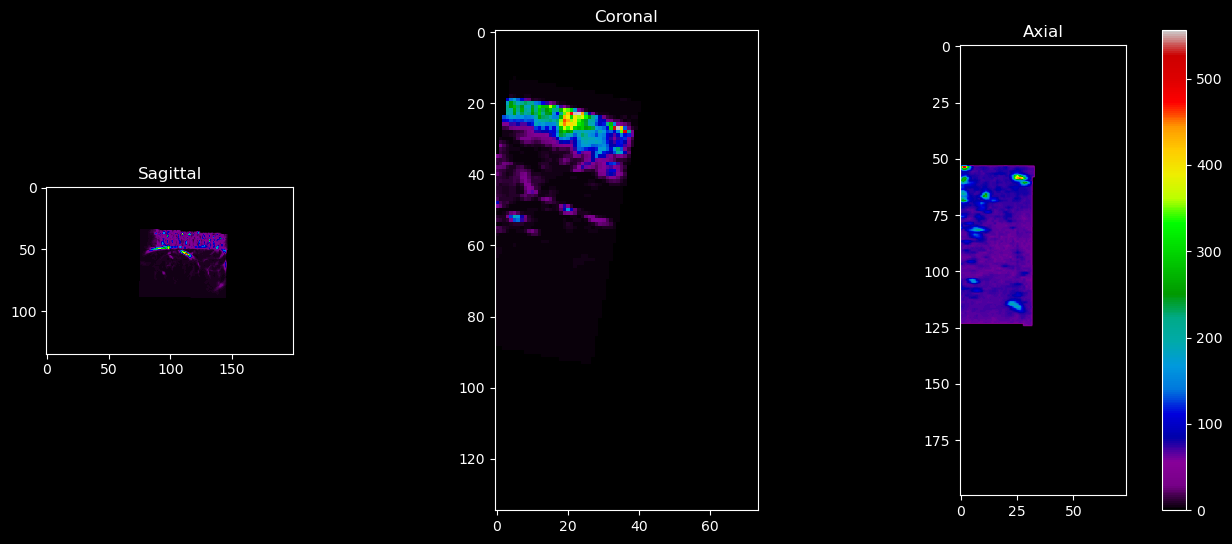

In [7]:
plot_slices(chunk_data, titles=["Sagittal", "Coronal", "Axial"])

### Identify X and Y boundaries in the coronal slice

In [8]:
# Find non-zero boundaries in the coronal slice
coronal_slice = np.max(chunk_data, axis=2)  # Max projection along the Z-axis

x_nonzero = np.any(coronal_slice, axis=1)
y_nonzero = np.any(coronal_slice, axis=0)

x_start, x_end = np.where(x_nonzero)[0][[0, -1]]
y_start, y_end = np.where(y_nonzero)[0][[0, -1]]

print("X boundaries:", x_start, x_end)
print("Y boundaries:", y_start, y_end)


X boundaries: 0 40
Y boundaries: 75 146


## Identify the Z boundary in the sagittal slice

In [9]:
# Find non-zero boundary in the sagittal slice
sagittal_slice = np.max(chunk_data, axis=0)  # Max projection along the X-axis

z_nonzero = np.any(sagittal_slice, axis=0)

z_start, z_end = np.where(z_nonzero)[0][[0, -1]]

print("Z boundaries:", z_start, z_end)

Z boundaries: 40 121


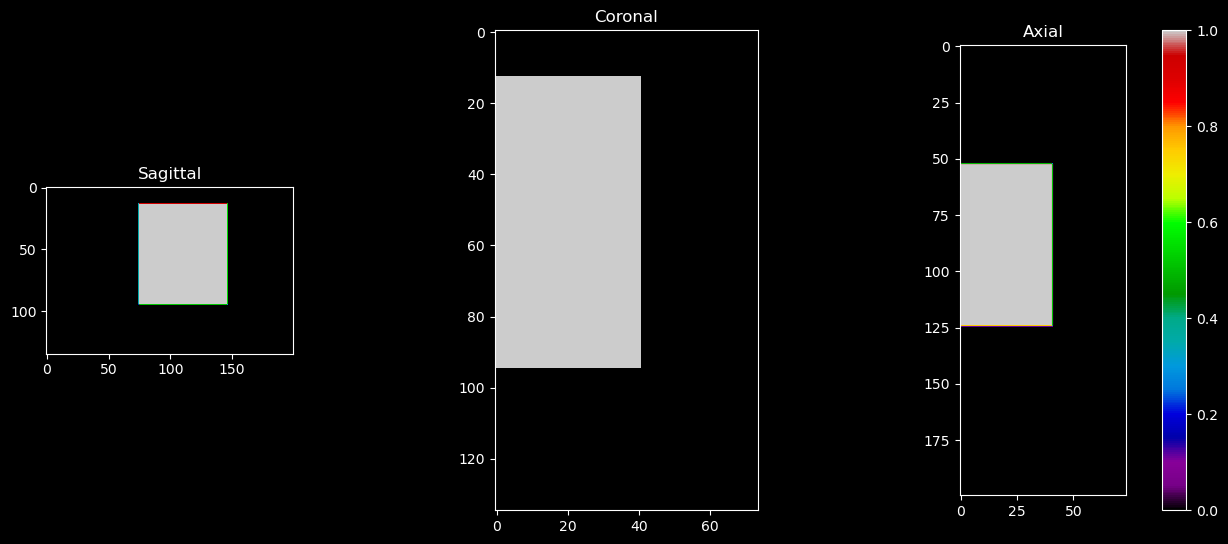

In [13]:
# Create a copy of chunk_data to highlight boundaries
chunk_highlight = np.zeros_like(chunk_data)

# Highlight the boundaries
chunk_highlight[x_start:x_end+1, y_start:y_end+1, z_start:z_end+1] = 1

plot_slices(chunk_highlight, titles=["Sagittal", "Coronal", "Axial"])

In [10]:
def map_labels(atlas_img, chunk_img, chunk_highlight):
    atlas_data = atlas_img.get_fdata()
    atlas_affine = atlas_img.affine
    chunk_affine = chunk_img.affine
    
    chunk_origin_world = np.dot(chunk_affine, [0, 0, 0, 1])[:3]
    chunk_origin_atlas_voxel = np.linalg.inv(atlas_affine).dot(np.append(chunk_origin_world, 1))[:3]
    chunk_origin_atlas_voxel = np.round(chunk_origin_atlas_voxel).astype(int)

    # Find the extent of the chunk in the atlas space
    chunk_extent_world = np.dot(chunk_affine, np.array([chunk_data.shape[0], chunk_data.shape[1], chunk_data.shape[2], 1]) - 1)[:3]
    chunk_extent_atlas_voxel = np.linalg.inv(atlas_affine).dot(np.append(chunk_extent_world, 1))[:3]
    chunk_extent_atlas_voxel = np.round(chunk_extent_atlas_voxel).astype(int)

    # Extract the corresponding region from the atlas
    chunk_labels = atlas_data[
        chunk_origin_atlas_voxel[0]:chunk_extent_atlas_voxel[0] + 1,
        chunk_origin_atlas_voxel[1]:chunk_extent_atlas_voxel[1] + 1,
        chunk_origin_atlas_voxel[2]:chunk_extent_atlas_voxel[2] + 1
    ]

    # Apply the mask to the extracted region
    chunk_labels = chunk_labels * chunk_highlight

    # Save the chunk labels as a new NIfTI file with dtype=int32
    chunk_labels_img = nib.Nifti1Image(chunk_labels.astype(np.int32), chunk_affine, header=nib.Nifti1Header())
    # chunk_labels_path = 'path/to/chunk_labels.nii'
    # nib.save(chunk_labels_img, chunk_labels_path)

    # print(f"Chunk labels saved to: {chunk_labels_path}")

    return chunk_labels_img


In [14]:
cortical_labels_img = map_labels(cortical_atlas_img, chunk_img, chunk_highlight)

subcortical_labels_img = map_labels(subcortical_atlas_img, chunk_img, chunk_highlight)

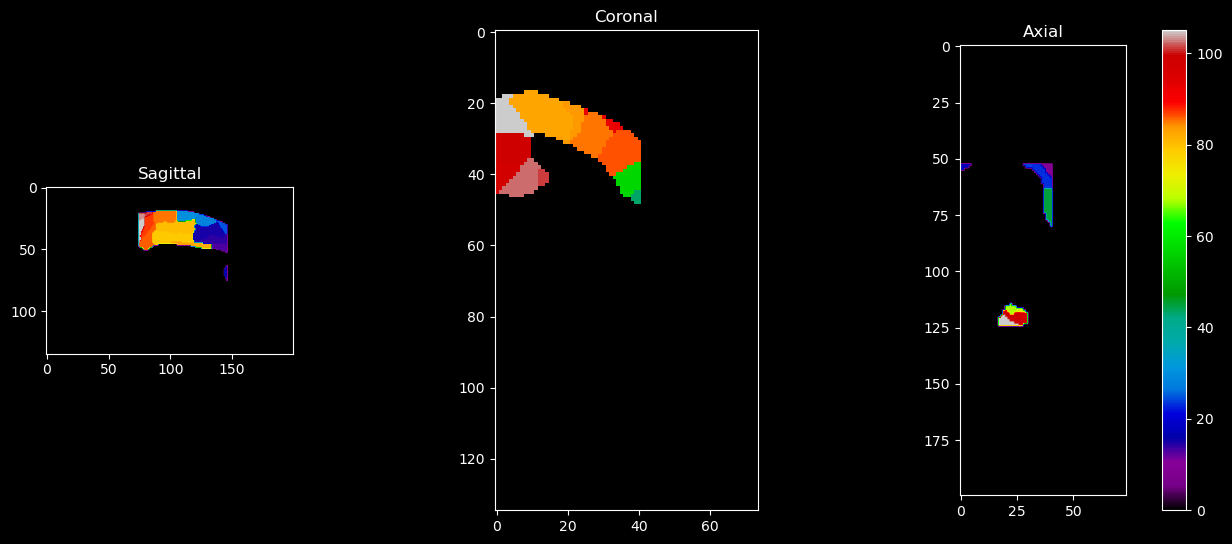

In [15]:
chunk_labels_data_cortical = cortical_labels_img.get_fdata()
plot_slices(chunk_labels_data_cortical, titles=["Sagittal", "Coronal", "Axial"])


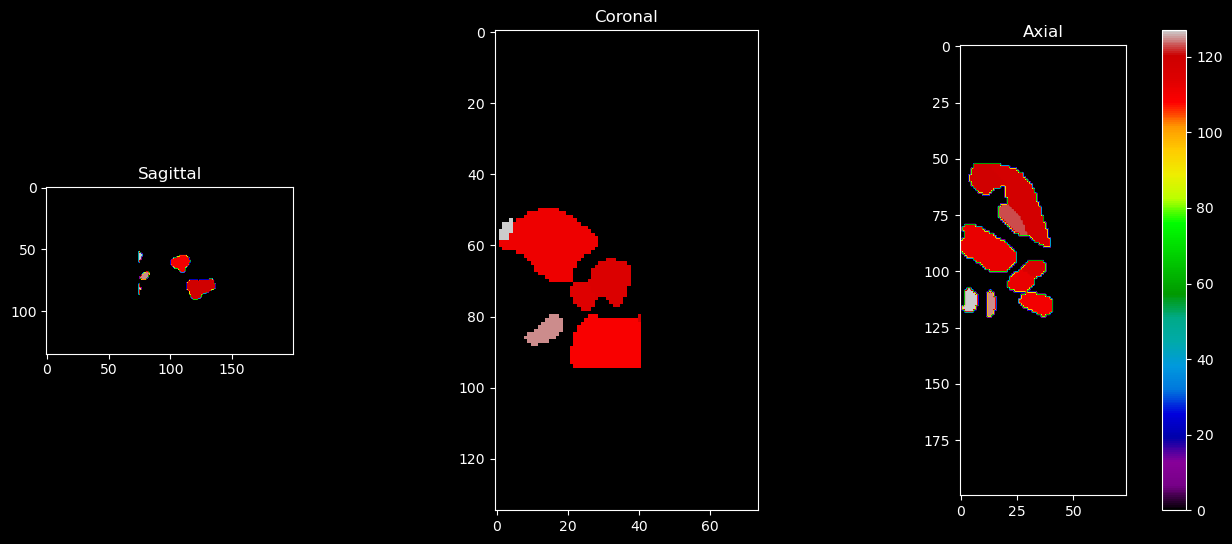

In [16]:
chunk_labels_data_subcortical = subcortical_labels_img.get_fdata()
chunk_labels_data_subcortical_revised = np.copy(chunk_labels_data_subcortical)
chunk_labels_data_subcortical_revised[chunk_labels_data_subcortical>0] +=107
plot_slices(chunk_labels_data_subcortical_revised, titles=["Sagittal", "Coronal", "Axial"])


In [17]:
cortical_labels = {
    "DLPFC": np.arange(1,6,1),
    "VLPFC": np.arange(6,10,1),
    "MPFC": np.arange(10,17,1),
    "OFC": np.arange(17,24,1),
    "Motor and premotor": np.arange(24,29,1),
    "Somatosensory": np.arange(29,34,1),
    "Auditory": np.arange(34,40,1),
    "Insula and others": np.arange(40,47,1),
    "Lateral and inferior temporal": np.arange(47,58,1),
    "Ventral temporal": np.arange(58,67,1),
    "Posterior parietal": np.arange(67,79,1),
    "Posterior cingulate and restrospenial ": np.arange(79,89,1),
    "Visual": np.arange(89,107,1),
}

subcortical_labels_df = pd.read_csv("/Users/yibeichen/Desktop/fusi/atlas/atlas_MBM_subcortical_beta_label.csv")
subcortical_labels_df["Labels"] = subcortical_labels_df["Labels"] + 107
subcortical_labels = dict(zip(subcortical_labels_df["Name"], subcortical_labels_df["Labels"]))

label_dict = cortical_labels | subcortical_labels
# make sure all values are array
for k, v in label_dict.items():
    label_dict[k] = np.array(v)

# based on label_dict keys, generate a new dict which gives the index of each label
idx = np.arange(1, len(label_dict.keys())+1, 1)
label_idx_dict = dict(zip(label_dict.keys(), idx))

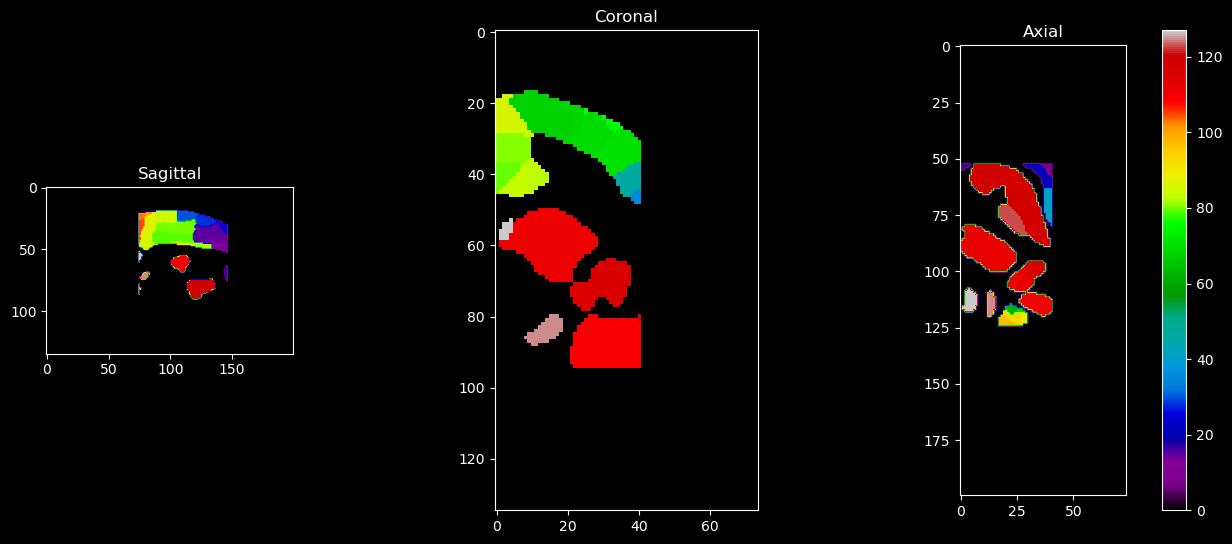

In [18]:
chunk_labels_data = cortical_labels_img.get_fdata() + chunk_labels_data_subcortical_revised
plot_slices(chunk_labels_data, titles=["Sagittal", "Coronal", "Axial"])


In [19]:
chunk_label_new = np.zeros_like(chunk_labels_data)
for i in np.unique(chunk_labels_data):
    for k, v in label_dict.items():
        if i in v:
            chunk_label_new[chunk_labels_data == i] = label_idx_dict[k]

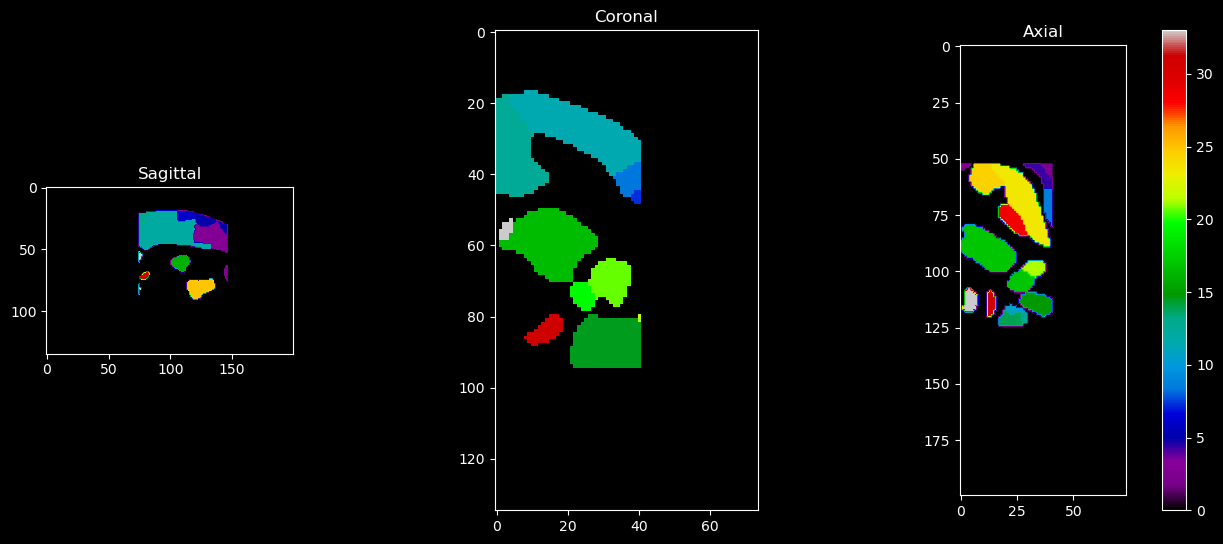

In [20]:
plot_slices(chunk_label_new, titles=["Sagittal", "Coronal", "Axial"])


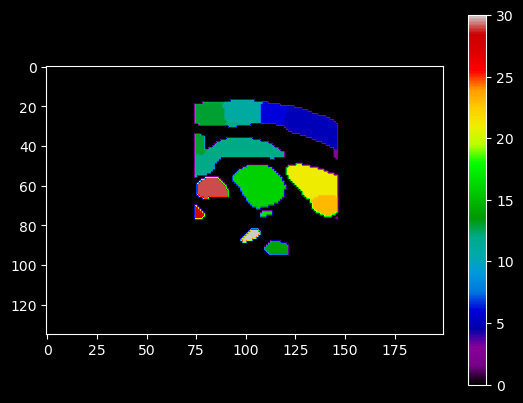

In [21]:
plt.imshow(np.rot90(chunk_label_new[10]), cmap='nipy_spectral')
plt.colorbar()
plt.show()

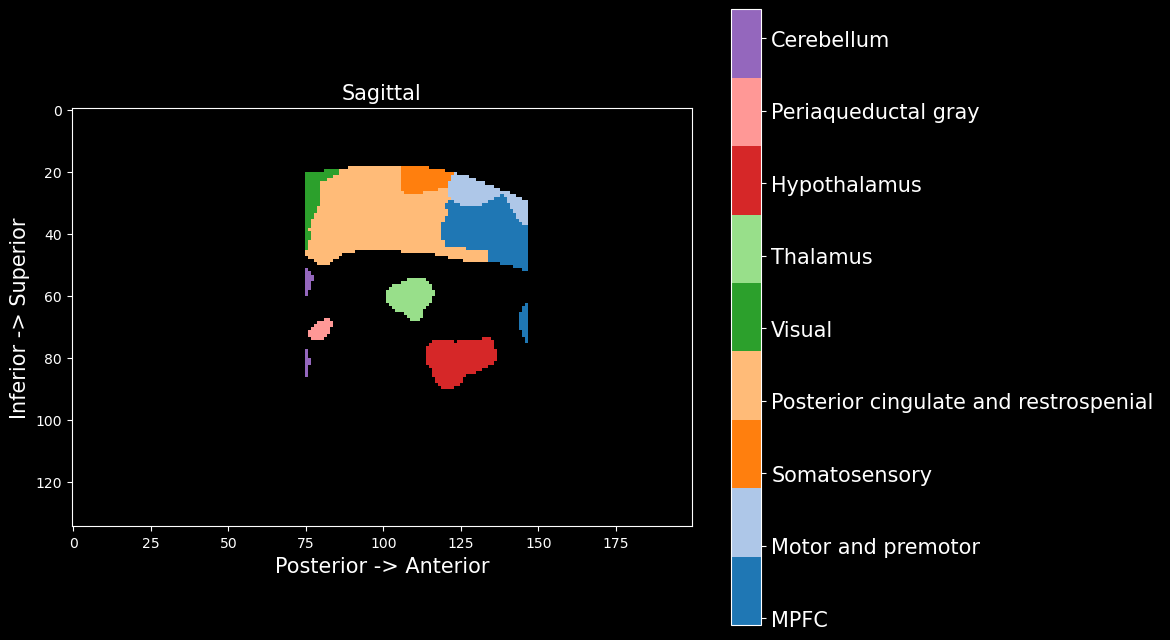

In [34]:
label_idx_dict_inverse = {v: k for k, v in label_idx_dict.items()}
x_index = 0
slice_data = np.rot90(chunk_label_new[x_index, :, :])

masked_slice_data = np.ma.masked_where(slice_data == 0, slice_data)
unique_values = np.unique(masked_slice_data.compressed())

value_map = {old: new for new, old in enumerate(unique_values, start=1)}
default_value = 0
mapped_slice_data = np.vectorize(lambda x: value_map.get(x, default_value))(masked_slice_data)

colors = sns.color_palette(palette="tab20", n_colors=len(unique_values)).as_hex()
# Create a ListedColormap
cmap = mcolors.ListedColormap(colors)

fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.imshow(mapped_slice_data, cmap=cmap, vmin=1, vmax=len(unique_values) + 0.5)

# Calculate the midpoints for each color block
midpoints = np.arange(1, len(unique_values) + 1)  + 0.9 / len(unique_values)

# Create a color bar with labels
cbar = plt.colorbar(cax, ticks=midpoints)
cbar.set_ticklabels([label_idx_dict_inverse[val] for val in unique_values], fontsize=15)

                         
# Add labels and title
ax.set_xlabel('Posterior -> Anterior', fontsize=15)
ax.set_ylabel('Inferior -> Superior', fontsize=15)
ax.set_title('Sagittal', fontsize=15)


# Show the plot
plt.show()

## Task data

In [146]:
video_file = "/Users/yibeichen/Desktop/fusi/task_data/0227_socialvideo_Plane1.5.mat"
marmoset_file = "/Users/yibeichen/Desktop/fusi/task_data/0618_livemarmoset_Plane1.5.mat"

In [147]:
video_data = sio.loadmat(video_file)
marmoset_data = sio.loadmat(marmoset_file)

In [511]:
video_data_2d = np.mean(np.squeeze(video_data["Data"]), axis=2).T
marmoset_data_2d = np.mean(np.squeeze(marmoset_data["Data"]), axis=2).T
marmoset_data_2d = np.flip(marmoset_data_2d, axis=1)
video_data_2d.shape, marmoset_data_2d.shape

((153, 128), (143, 128))

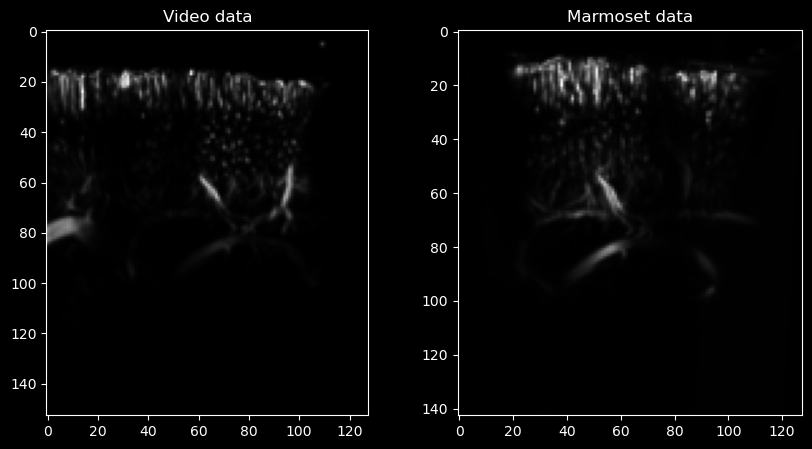

In [521]:
# plot the 2d data side-by-side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(video_data_2d, cmap='gray')
axes[0].set_title('Video data')
axes[1].imshow(marmoset_data_2d, cmap='gray')
axes[1].set_title('Marmoset data')
plt.show()

In [368]:
transform_file = "/Users/yibeichen/Desktop/fusi/chunk2whole/Transform.h5"

with h5py.File(transform_file, 'r') as f:
    print("Keys in H5 file:", list(f.keys()))
    transform_group = f['TransformGroup']
    print("Keys in TransformGroup:", list(transform_group['0'].keys()))
    # Assuming the transformation matrix is stored under 'TransformParameters'
    transform_parameters = transform_group['0']['TransformParameters']
    T_flat = np.array(transform_parameters)

Keys in H5 file: ['HDFVersion', 'ITKVersion', 'OSName', 'OSVersion', 'TransformGroup']
Keys in TransformGroup: ['TransformFixedParameters', 'TransformParameters', 'TransformType']


In [385]:
chunk_data.shape

(74, 200, 135)

In [386]:
def transform_slice(data, T_2D):
    transformed_chunk_yz = [0.2, 0.2]  # Example pixel sizes in mm for A in the y and z dimensions
    slice_yz = [0.11, 0.098]
    zoom_factors = [transformed_chunk_yz[0] / slice_yz[0], transformed_chunk_yz[1] / slice_yz[1]]
    resampled_D = zoom(data, zoom_factors)
    print(f"unique values in resampled_D: {np.unique(resampled_D)}")
    # Define the inverse of the affine matrix for scipy affine_transform function
    affine_matrix_inv = np.linalg.inv(T_2D)

    # Remove the last row and column to get the 2x3 matrix for affine_transform
    affine_matrix_inv_2x3 = affine_matrix_inv[:2, :3]

    # Apply the affine transformation using scipy's affine_transform to the slice D
    transformed_D = affine_transform(
        resampled_D, 
        affine_matrix_inv_2x3,
        offset=0,
        output_shape=(200, 135),
        order=1,  # 1 for bilinear interpolation
        mode='constant',
        cval=0
    )
    print(f"unique values in transformed_D: {np.unique(transformed_D)}")
    return transformed_D



In [380]:
T_2D[:2, :2]

array([[ 0.02281899, -0.18486304],
       [-2.9719667 ,  0.47004326]])

In [387]:
T = T_flat.reshape(3, 4)

T_2D = np.array([
    [T[1, 1], T[1, 2], T[1, 3]],
    [T[2, 1], T[2, 2], T[2, 3]],
    [0, 0, 1]
])
transform_video = transform_slice(video_data_2d, T_2D)
transform_marmoset = transform_slice(marmoset_data_2d, T_2D)


unique values in resampled_D: [ -19.37165588  -13.64612708  -13.17537492 ... 1257.24538309 1276.11896576
 1317.50734165]
unique values in transformed_D: [0.]
unique values in resampled_D: [  2.19965739   2.34148867   2.76094293 ... 180.48102654 182.96681654
 188.89774269]
unique values in transformed_D: [0.]


In [395]:
def get_active_pixels(data, threshold):
    # Find rows and columns with values above the threshold
    y_nonzero = np.any(data >= threshold, axis=1)
    z_nonzero = np.any(data >= threshold, axis=0)
    
    # Get the start and end indices for rows and columns
    y_indices = np.where(y_nonzero)[0]
    z_indices = np.where(z_nonzero)[0]
    
    if y_indices.size > 0 and z_indices.size > 0:
        y_start, y_end = y_indices[[0, -1]]
        z_start, z_end = z_indices[[0, -1]]
    else:
        # If no active pixels are found, return None or an appropriate value
        y_start, y_end, z_start, z_end = None, None, None, None

    return y_start, y_end, z_start, z_end


Y boundaries: 4 100
Z boundaries: 0 111


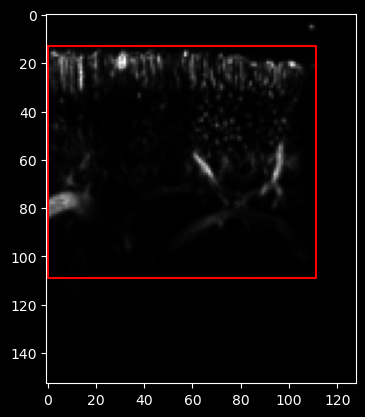

In [443]:
th = np.percentile(np.ravel(video_data_2d), 80)
y_start, y_end, z_start, z_end = get_active_pixels(video_data_2d, threshold=th)

print("Y boundaries:", y_start, y_end)
print("Z boundaries:", z_start, z_end)
# plot video data with boundaries
plt.imshow(video_data_2d, cmap='gray')
# Check if active pixels were found before plotting boundaries
adj = 9
if y_start is not None and z_start is not None:
    # Draw a rectangle to represent the boundaries
    plt.plot([z_start, z_end, z_end, z_start, z_start], [y_start+adj, y_start+adj, y_end+adj, y_end+adj, y_start+adj], 'r')

plt.show()

In [520]:
marmoset_data_2d.shape

(143, 128)

Y boundaries: 0 101
Z boundaries: 18 127


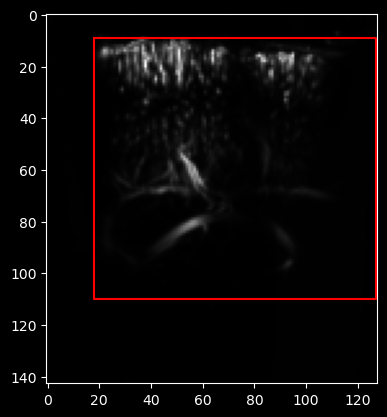

In [524]:
th = np.percentile(np.ravel(marmoset_data_2d), 75)
y_start, y_end, z_start, z_end = get_active_pixels(marmoset_data_2d, threshold=th)

print("Y boundaries:", y_start, y_end)
print("Z boundaries:", z_start, z_end)
# plot video data with boundaries
plt.imshow(marmoset_data_2d, cmap='gray')
# Check if active pixels were found before plotting boundaries
adj = 9
if y_start is not None and z_start is not None:
    # Draw a rectangle to represent the boundaries
    plt.plot([z_start, z_end, z_end, z_start, z_start], [y_start+adj, y_start+adj, y_end+adj, y_end+adj, y_start+adj], 'r')

plt.show()

In [393]:
y_start, y_end, z_start, z_end = get_active_pixels(marmoset_data_2d)

print("Y boundaries:", y_start, y_end)
print("Z boundaries:", z_start, z_end)

Y boundaries: 0 142
Z boundaries: 0 127


In [434]:
def get_active_chunks(data):
    # Find the coordinates of all the 1s in the 3D data
    x_nonzero = np.any(data, axis=(1, 2))
    y_nonzero = np.any(data, axis=(0, 2))
    z_nonzero = np.any(data, axis=(0, 1))
    
    # Get the start and end indices for x, y, and z dimensions
    x_indices = np.where(x_nonzero)[0]
    y_indices = np.where(y_nonzero)[0]
    z_indices = np.where(z_nonzero)[0]
    
    if x_indices.size > 0 and y_indices.size > 0 and z_indices.size > 0:
        x_start, x_end = x_indices[[0, -1]]
        y_start, y_end = y_indices[[0, -1]]
        z_start, z_end = z_indices[[0, -1]]
    else:
        # If no active chunks are found, return None or an appropriate value
        x_start, x_end, y_start, y_end, z_start, z_end = None, None, None, None, None, None

    return x_start, x_end, y_start, y_end, z_start, z_end


get_active_chunks(chunk_highlight)

(0, 40, 75, 146, 40, 121)

In [539]:
# Find the indices of the non-zero elements
non_zero_indices = np.argwhere(chunk_highlight[0])

# Get the coordinates of the rectangular region
start_row = np.min(non_zero_indices[:, 0])
end_row = np.max(non_zero_indices[:, 0])
start_col = np.min(non_zero_indices[:, 1])
end_col = np.max(non_zero_indices[:, 1])

# Output the coordinates
rectangle_coordinates = {
    'start_row': start_row,
    'end_row': end_row,
    'start_col': start_col,
    'end_col': end_col
}

print("Rectangle coordinates:", rectangle_coordinates)

Rectangle coordinates: {'start_row': 75, 'end_row': 146, 'start_col': 40, 'end_col': 121}


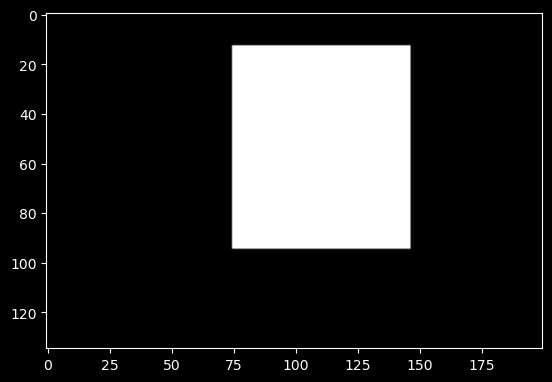

In [541]:
plt.imshow(np.rot90(chunk_highlight[0]), cmap='gray')
plt.show()

In [527]:
def fit_task2chunk(task_data, y0, y1, z0, z1, chunk_highlight):
    data = np.zeros_like(chunk_highlight[0])
    _, _, y_start, y_end, z_start, z_end = get_active_chunks(chunk_highlight)
    
    # Extract the task slice and rotate it back
    task_slice = np.rot90(task_data[z0:z1, y0:y1], k=-1)
    
    # Calculate the target dimensions
    target_height = y_end - y_start
    target_width = z_end - z_start
    
    # Resize the task slice to fit the chunk slice proportionally
    resized_task_slice = resize(task_slice, (target_height, target_width), mode='constant', preserve_range=True)
    
    # Place the resized task slice into the data
    data[y_start:y_end, z_start:z_end] = resized_task_slice
    
    return data

In [601]:
video_chunk = fit_task2chunk(video_data_2d, y0=0, y1=110, z0=10, z1=120, chunk_highlight=chunk_highlight)
marmoset_chunk = fit_task2chunk(marmoset_data_2d, y0=0, y1=105, z0=10, z1=121, chunk_highlight=chunk_highlight)

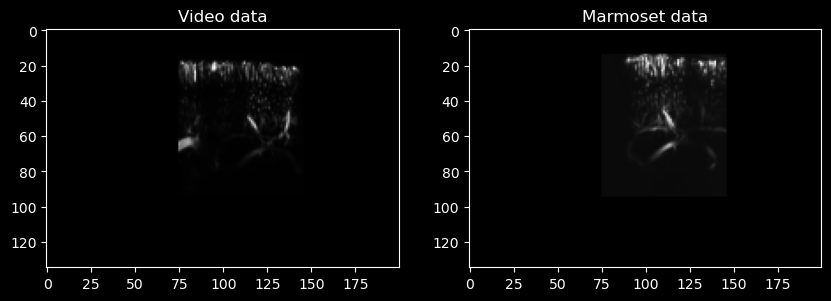

In [602]:
# plot the 2d data side-by-side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(np.rot90(video_chunk), cmap='gray')
axes[0].set_title('Video data')
axes[1].imshow(np.rot90(marmoset_chunk), cmap='gray')
axes[1].set_title('Marmoset data')
plt.show()

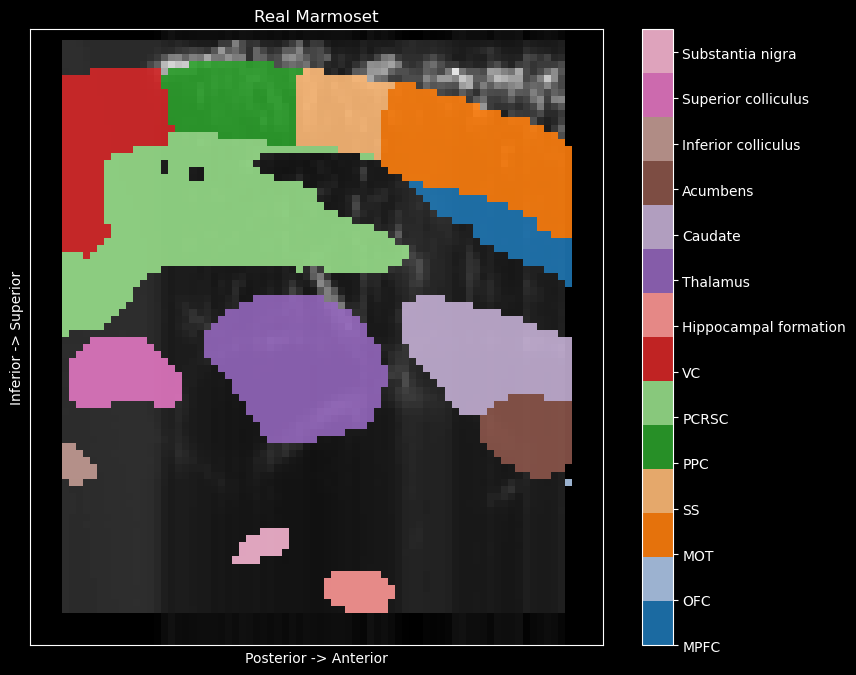

In [611]:
# Inverse label dictionary
label_idx_dict_inverse = {v: k for k, v in label_idx_dict.items()}

# Plot 1: 2D slice of 3D data
x_index = 9
slice_data = np.rot90(chunk_label_new[x_index, :, :])

masked_slice_data = np.ma.masked_where(slice_data == 0, slice_data)
unique_values = np.unique(masked_slice_data.compressed())

value_map = {old: new for new, old in enumerate(unique_values, start=1)}
default_value = 0
mapped_slice_data = np.vectorize(lambda x: value_map.get(x, default_value))(masked_slice_data)

colors = sns.color_palette(palette="tab20", n_colors=len(unique_values)).as_hex()
cmap = mcolors.ListedColormap(colors)

# Plot 2: Video data
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the video data in grayscale
ax.imshow(zscore(np.rot90(marmoset_chunk)), cmap='gray', alpha=0.9)

# Overlay the mapped slice data with transparency, excluding alpha for the colorbar
cax = ax.imshow(mapped_slice_data, cmap=cmap, vmin=1, vmax=len(unique_values)+0.5, alpha=0.9)

# Create a color bar with labels
cbar = plt.colorbar(cax, ticks=np.arange(1, len(unique_values) + 1), ax=ax)
cbar.set_ticks(np.arange(1, len(unique_values)+1))
cbar.set_ticklabels([label_idx_dict_inverse[val] for val in unique_values])

# Remove x and y ticks and tick labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

# Cut off the 0s around by determining the bounding box of the non-zero region
non_zero_indices = np.argwhere(mapped_slice_data > 0)
(xmin, ymin), (xmax, ymax) = non_zero_indices.min(0), non_zero_indices.max(0)

# Add margins
margin = 5  # Adjust the margin size as needed
ax.set_xlim(max(ymin - margin, 0), min(ymax + margin, mapped_slice_data.shape[1]))
ax.set_ylim(min(xmax + margin, mapped_slice_data.shape[0]), max(xmin - margin, 0))  # inverted due to the rotation

# Add labels and title
ax.set_xlabel('Posterior -> Anterior')
ax.set_ylabel('Inferior -> Superior')
ax.set_title('Real Marmoset')

# Show the plot
plt.show()
# save the plot
# fig.savefig('/Users/yibeichen/Documents/GitHub/fUSi-workflow/output/atlas_only.svg', dpi=300)

In [486]:
video_chunk.shape

(200, 135)